# This is the first example of Linear Regression: House Price Prediction

In [1]:
import os
import tarfile
import urllib.request
import pandas as pd

## Fetching data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/mlbvn/handson-ml2-vn/main/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("datasets", "housing")
## Fetching data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
## Loading data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data() # Fetching house data
house = load_housing_data()
house.info()
# some value of total_bedrooms is missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# count element for every attributes
house.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Histogram of data
### Describe the frequency of value

In [5]:
# command Jupyter using its own backend for matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
# house["median_income"].hist(bins=50, figsize=(20,15))
# plt.show()
house["median_income"].value_counts()

median_income
3.1250     49
15.0001    49
2.8750     46
2.6250     44
4.1250     44
           ..
4.0774      1
4.1767      1
6.1814      1
6.4319      1
2.0943      1
Name: count, Length: 12928, dtype: int64

## Split data into train_data and test_data

In [6]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # if every time the system re-run a
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indces = shuffled_indices[test_set_size:]
    return data.iloc[train_indces], data.iloc[test_indices]
## Phu thuoc vao ham random trong numpy, khi ma moi lan chay lai thi shuffled_indices se cho ra ket qua khac luc do ham split se chay qua het tat ca du lieu

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(house, test_size=0.2, random_state=42)
print(len(train_data))
print(len(test_data))

16512
4128


<Axes: >

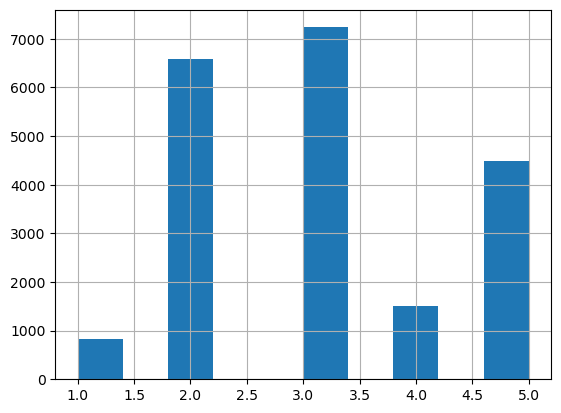

In [8]:
house["income_cat"] = pd.cut(house["median_income"], 
                             bins=[0, 1.5, 3.0, 4.5, 5., np.inf],
                             labels=[1, 2, 3, 4, 5])
house["income_cat"].hist()

### StratifiedShuffle

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(house, house["income_cat"]):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
5    0.217539
4    0.073159
1    0.039971
Name: count, dtype: float64

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Data Exploration and Visualization

In [11]:
housing = strat_train_set.copy()

## Data Visualization

<Axes: xlabel='longitude', ylabel='latitude'>

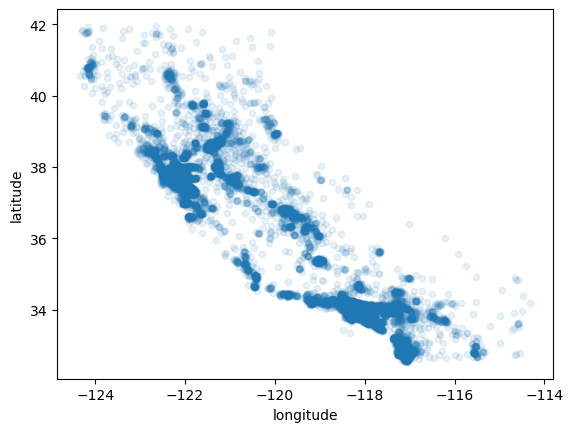

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

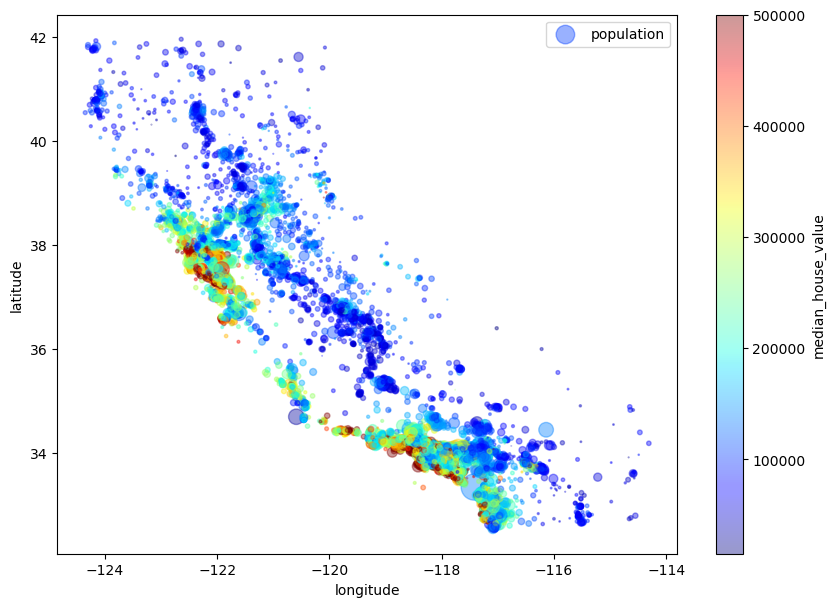

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",figsize=(10, 7), 
            c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True
        )
plt.legend()

In [14]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20075,-120.28,38.07,13.0,1996.0,410.0,618.0,218.0,2.9083,104600.0,INLAND
17216,-119.71,34.43,48.0,2408.0,536.0,1005.0,497.0,3.5213,458600.0,<1H OCEAN
5618,-118.23,33.78,20.0,59.0,24.0,69.0,23.0,2.5588,350000.0,NEAR OCEAN
12413,-116.22,33.74,26.0,4120.0,858.0,2918.0,815.0,3.3107,69400.0,INLAND
2025,-119.74,36.71,17.0,5872.0,1250.0,5034.0,1224.0,2.1905,61800.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
3327,-122.83,38.89,11.0,640.0,134.0,268.0,90.0,3.4514,100000.0,<1H OCEAN
20131,-118.92,34.41,22.0,2702.0,655.0,2664.0,571.0,3.0893,173400.0,<1H OCEAN
18341,-122.14,37.43,52.0,1327.0,190.0,467.0,189.0,12.5902,500001.0,NEAR BAY
9661,-120.87,41.54,21.0,1091.0,208.0,660.0,188.0,2.2321,34600.0,INLAND


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

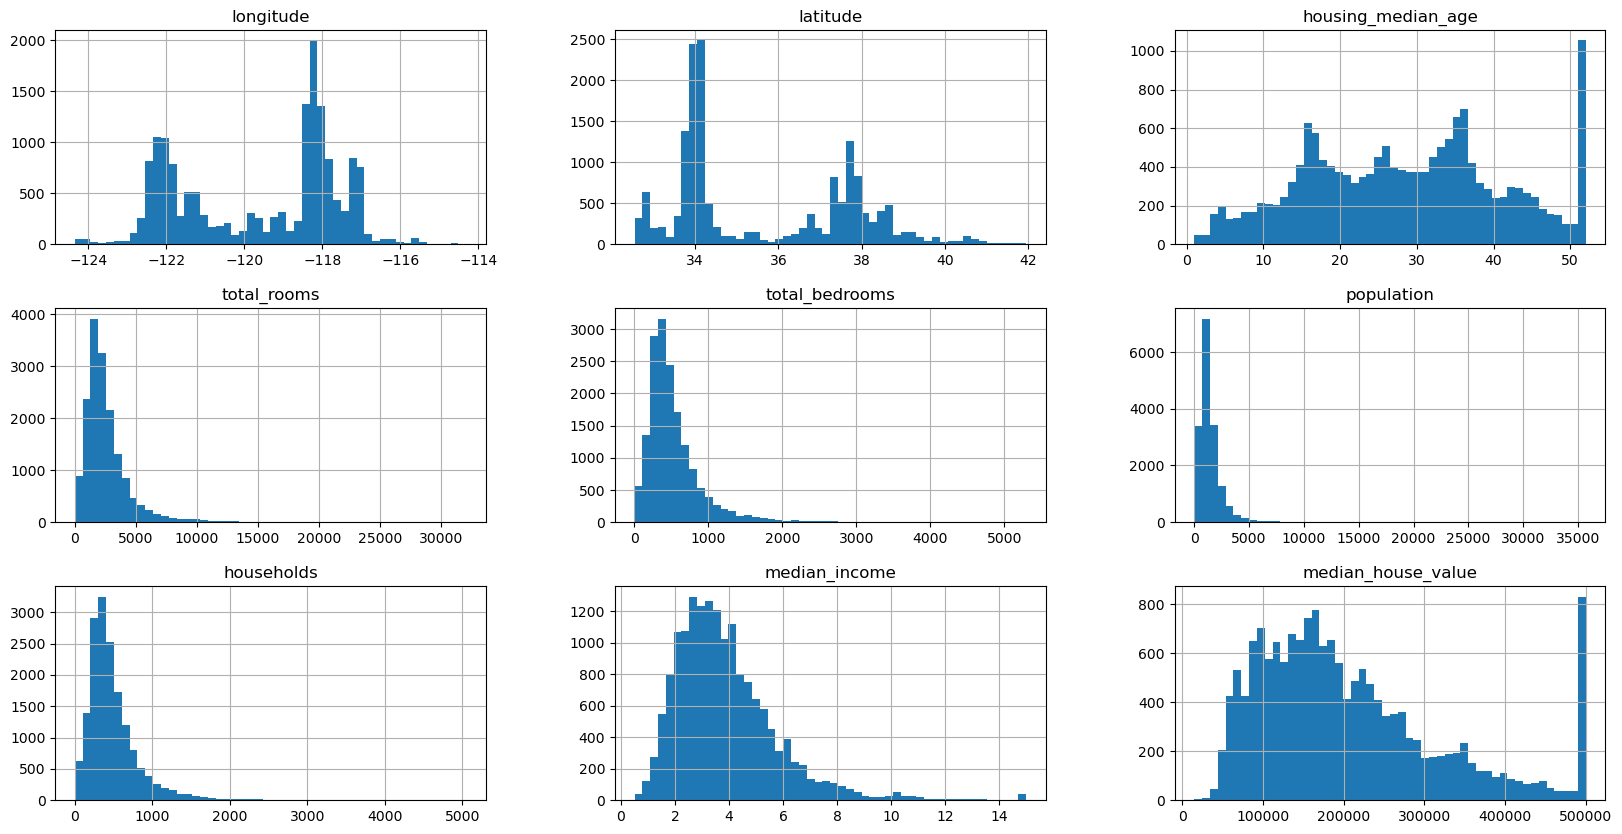

In [15]:
housing.hist(bins=50, figsize=(20, 10))

In [16]:
corr_matrix = housing.corr(numeric_only=True)

In [17]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686469
total_rooms           0.134953
housing_median_age    0.107350
households            0.064122
total_bedrooms        0.046762
population           -0.024778
longitude            -0.049269
latitude             -0.141110
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

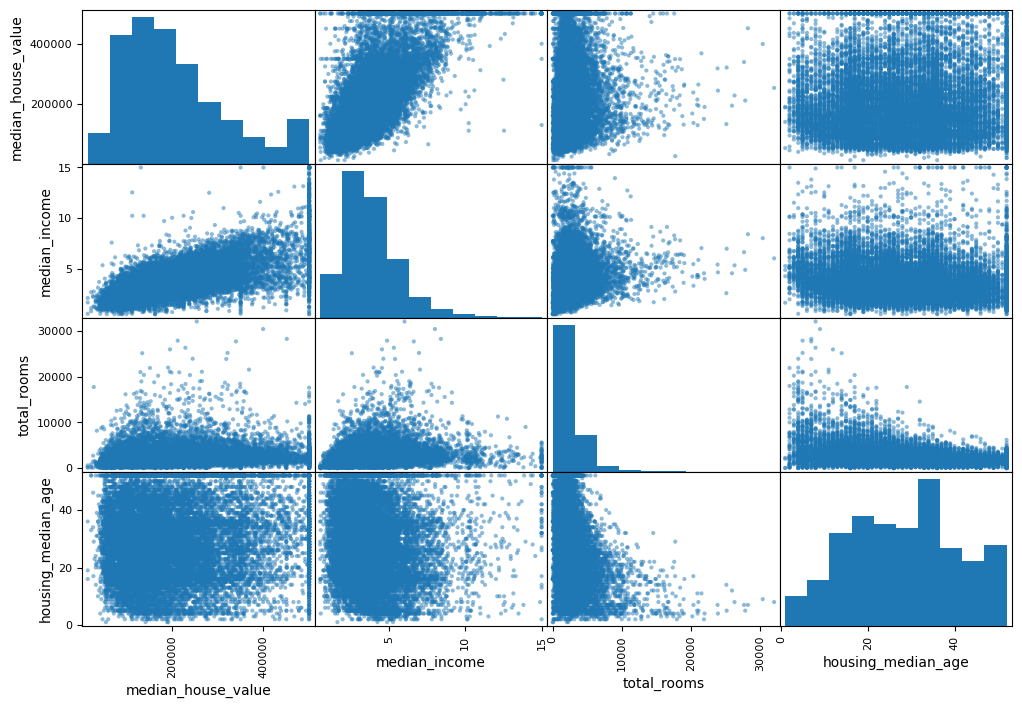

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

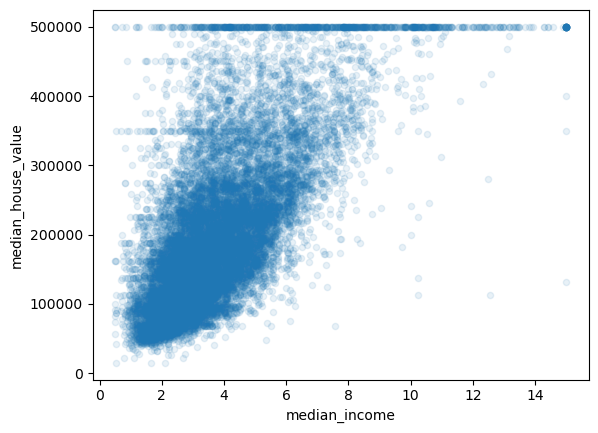

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [20]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [21]:
corr_matrix = housing.corr(numeric_only=True)

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686469
rooms_per_household         0.145598
total_rooms                 0.134953
housing_median_age          0.107350
households                  0.064122
total_bedrooms              0.046762
population_per_household   -0.022073
population                 -0.024778
longitude                  -0.049269
latitude                   -0.141110
bedrooms_per_room          -0.259476
Name: median_house_value, dtype: float64

## Prepare data for Models

In [23]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [25]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num2 = housing_num

In [26]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
imputer.statistics_

array([-118.52   ,   34.26   ,   29.     , 2119.     ,  432.     ,
       1163.     ,  407.     ,    3.54155])

In [28]:
housing_num.median().values

array([-118.52   ,   34.26   ,   29.     , 2119.     ,  432.     ,
       1163.     ,  407.     ,    3.54155])

In [29]:
X = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 20075 to 15080
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


# Process text and category data

In [31]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
20075,INLAND
17216,<1H OCEAN
5618,NEAR OCEAN
12413,INLAND
2025,INLAND
6388,INLAND
4073,<1H OCEAN
15291,NEAR OCEAN
18058,<1H OCEAN
5369,<1H OCEAN


In [32]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [0.],
       [4.],
       [1.],
       [1.],
       [1.],
       [0.],
       [4.],
       [0.],
       [0.]])

In [33]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [34]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
housing_cat_onehot = onehot_encoder.fit_transform(housing_cat)
housing_cat_onehot

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

## Customized Transformer

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[0]

array([-120.28, 38.07, 13.0, 1996.0, 410.0, 618.0, 218.0, 2.9083,
       'INLAND', 9.155963302752294, 2.834862385321101], dtype=object)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ("std_scaler", StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num2)
housing_num_tr[0]

array([-0.35169772,  1.13759414, -1.24107809, -0.29405688, -0.30260975,
       -0.71921042, -0.74144514, -0.50728928,  1.4205629 , -0.02209134])

In [37]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num2)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(sparse_output=False), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)
print((housing_prepared[0]))
print(num_attribs)

[-0.35169772  1.13759414 -1.24107809 -0.29405688 -0.30260975 -0.71921042
 -0.74144514 -0.50728928  1.4205629  -0.02209134  0.          1.
  0.          0.          0.        ]
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


# Choosing and Train a Model

## 1. Train and Evaluate on Training set

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
# Testing on some data

LinearRegression()

In [39]:
sample_data = housing.iloc[:680]
sample_labels = housing_labels.iloc[:680]
sample_prepared = full_pipeline.fit_transform(sample_data)

print("Predictions: ", lin_reg.predict(sample_prepared))
print("Lables:", list(sample_labels))
## OneHotEncoder sẽ phụ thuộc vào số lượng category data có trong một bảng dữ lieu:
## Vi du: Neu co mang ["one", "two", "three"] thi se ma hoa ra mang co 3 phan tu. No se anh huong neu gia su minh lay train data ma 
## chi xuat hien 3 category thi se khong tong quat

Predictions:  [ 85445.71803327 274127.57630784 152328.30539938  89672.12269961
  32037.95652796 293516.74257785 382756.07571406 227106.27237202
 424204.33544578 335616.382493   323583.75937931 305330.73722884
 109427.33698804  99407.53395578 286253.25145767  91010.24463976
 382202.94293075  92584.13067755  82866.19293552 158648.42273486
 247652.57335406  -6012.35890732 255175.29839259 102091.82677338
 229669.60898763 300969.09064769 223191.08407885 189130.83158617
 285055.58960966 333551.68852873 286613.08682117 107172.24577459
 292147.79673882 129405.79048102  95322.39152188 130111.2410962
  25940.75527    150476.38975903 258818.52998001 216000.85898731
 294744.35854111 111726.19963316 141729.92700933  76057.49700063
  61813.57959424 179433.29012011 207767.75930882   3948.3444011
 170022.7615575  146235.97764489 114209.05384441 161552.75347287
  89710.69116185  93315.5520995  202823.06162073 285545.37025177
 255751.63259415 197943.52779874 458812.60059647 102068.42496787
 208891.63717

In [40]:
# Calculate RMSE 
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68924.01392889819

In [41]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## K-Fold Cross Validation

In [44]:
from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print(tree_rmse_scores)
print("Mean: ", tree_rmse_scores.mean())
print("Standard Deviation: ", tree_rmse_scores.std())

[74568.38788058 71444.31374169 67113.71363046 72568.32459157
 64849.00489238 72340.50176468 72944.97000469 68206.49076314
 72180.22265653 68061.00852058]
Mean:  70427.69384463108
Standard Deviation:  2974.3438198843387


In [45]:
## Calculate Cross validation scores for linear_regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)
print("Mean: ", lin_rmse_scores.mean())
print("Standard Deviation: ", lin_rmse_scores.std())

[72097.99521001 66692.22229211 71634.65958386 74085.90882152
 63985.54139781 68989.50106887 70242.08410085 65581.069517
 68556.32950186 70122.69329642]
Mean:  69198.8004790304
Standard Deviation:  2952.4590300270343


In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor()

In [47]:
## Calculate K-fold for Random forest Regressor
forest_score = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
print(forest_score)
print("Mean: ", forest_score.mean())
print("Standard Deviation: ", forest_score.std())

[-2.63153663e+09 -2.38964116e+09 -2.25253891e+09 -2.78676736e+09
 -2.26139932e+09 -2.42134143e+09 -2.83393648e+09 -2.19288700e+09
 -2.48537425e+09 -2.98224103e+09]
Mean:  -2523766355.768328
Standard Deviation:  258655142.39836147


In [49]:
import joblib
joblib.dump(forest_score, "random_forest.pkl")

['random_forest.pkl']